## Description of notebook

In this notebook, an usupervised bias detection tool is applied on synthetic data of the CUB process from 2014. The synthetic dataset (n=20.000) reflects group level characteristics of students that were registered to receive a college grant on 01-02-2014 by the Dutch Executive Education Agency (DUO). A clustering algorithm is applied to identify groups of similar students that are treated differently.

## Table of contents

0. Import libraries and data
1. Data processing
2. Clustering
3. Analysis of cluster with most bias
4. Analysis of all identifief clusters

## 0. Import libraries and data

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_function import diff_df
from unsupervised_bias_detection.clustering import BiasAwareHierarchicalKModes
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/Table1_SD_20k.csv', sep=",", index_col='Unnamed: 0')
df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal
0,MBO 3-4,19-20,5-10km,5,Not available,NaN
1,WO,25-50,50-500km,4,Not available,NaN
2,MBO 3-4,19-20,50-500km,5,Not available,NaN
3,WO,21-22,20-50km,6,Not available,NaN
4,WO,19-20,50-500km,2,Not available,NaN


In [2]:
df.shape

(20000, 6)

## 1. Data processing

In [3]:
# mapping high risk categories to 0 (more bias) and low risk categories to 1 (less bias)
mapping = {6:1, 5:1, 4:0, 3:0, 2:0, 1:0}
df['Risk category'] = df['Risk category'].map(mapping)

# performance metric
targetColumn = 'Risk category'

# feature columns
features = ['Education', 'Age', 'Distance']
X = df[features]

# target column in df
y = df[targetColumn]

In [4]:
df.head()

,Education,Age,Distance,Risk category,Outcome house visit,Outcome appeal
0,MBO 3-4,19-20,5-10km,1,Not available,NaN
1,WO,25-50,50-500km,0,Not available,NaN
2,MBO 3-4,19-20,50-500km,1,Not available,NaN
3,WO,21-22,20-50km,1,Not available,NaN
4,WO,19-20,50-500km,0,Not available,NaN


## 2. Clustering

In [5]:
#clustering paramters 
n_iter=20
min_cluster_size=750

# clustering
hbac = BiasAwareHierarchicalKModes(n_iter=n_iter, min_cluster_size=min_cluster_size).fit(X, y)

In [6]:
# UI text
print(f'Parameters selected\nNumber of iterations: {n_iter}\nMinimal cluster size: {min_cluster_size}')

Parameters selected
Number of iterations: 20
Minimal cluster size: 750


In [7]:
# csv export
hbac.n_iter
hbac.min_cluster_size

750

In [8]:
# csv export
hbac.scores_

array([ 0.0597777 ,  0.0364168 ,  0.02072472,  0.00587807, -0.00048727,
       -0.01217349, -0.02518748])

In [9]:
# assign cluster labels to the original dataframe
df['Cluster'] = hbac.labels_

# cluster with most bias has label 0
df_most_biased_cluster = df[hbac.labels_ == 0]
df_other = df[hbac.labels_ != 0]

# UI text
print(f'We found {hbac.n_clusters_} clusters.\nCluster with most bias consists of {len(df_most_biased_cluster)} datapoints. The uploaded dataset consists of {df.shape[0]} datapoints.')

# csv export
hbac.n_clusters_
hbac.labels_
hbac.scores_

We found 7 clusters.
Cluster with most bias consists of 939 datapoints. The uploaded dataset consists of 20000 datapoints.


array([ 0.0597777 ,  0.0364168 ,  0.02072472,  0.00587807, -0.00048727,
       -0.01217349, -0.02518748])

## 3. Analysis of cluster with most bias

### 3a. Most deviating cluster vs rest of dataset

In [10]:
# df with all differences
diff_df = diff_df(df, features, type='Categorical')
diff_df

,Difference
HBO,-6715.00000
MBO 1-2,0.00000
MBO 3-4,0.00000
WO,0.00000
15-18,-1268.00000
19-20,0.00000
21-22,0.00000
23-24,-2088.00000
25-50,-1794.00000
0km,-315.00000


In [11]:
# UI text 
print('In the most biased cluster datapoints have:')
for feat in features:
    values = df[feat].unique().tolist()
    for value in values:
        diff = diff_df.loc[value,"Difference"].round(2)
        if diff < 0:
            print(f'{abs(diff)} less {value} than in the rest of the dataset.')
        elif diff > 0:
            print(f'{diff} more {value} than in the rest of the dataset.')
        elif diff == 0:
            print(f'equal {value} as in the rest of the dataset.')

In the most biased cluster datapoints have:
equal MBO 3-4 as in the rest of the dataset.
equal WO as in the rest of the dataset.
6715.0 less HBO than in the rest of the dataset.
equal MBO 1-2 as in the rest of the dataset.
equal 19-20 as in the rest of the dataset.
1794.0 less 25-50 than in the rest of the dataset.
equal 21-22 as in the rest of the dataset.
1268.0 less 15-18 than in the rest of the dataset.
2088.0 less 23-24 than in the rest of the dataset.
1143.0 less 5-10km than in the rest of the dataset.
equal 50-500km as in the rest of the dataset.
2539.0 less 20-50km than in the rest of the dataset.
1382.0 less 2-5km than in the rest of the dataset.
1388.0 less 10-20km than in the rest of the dataset.
equal Not available as in the rest of the dataset.
665.0 less 1m-1km than in the rest of the dataset.
315.0 less 0km than in the rest of the dataset.
789.0 less 1-2km than in the rest of the dataset.


## 4. Analysis of all identified clusters

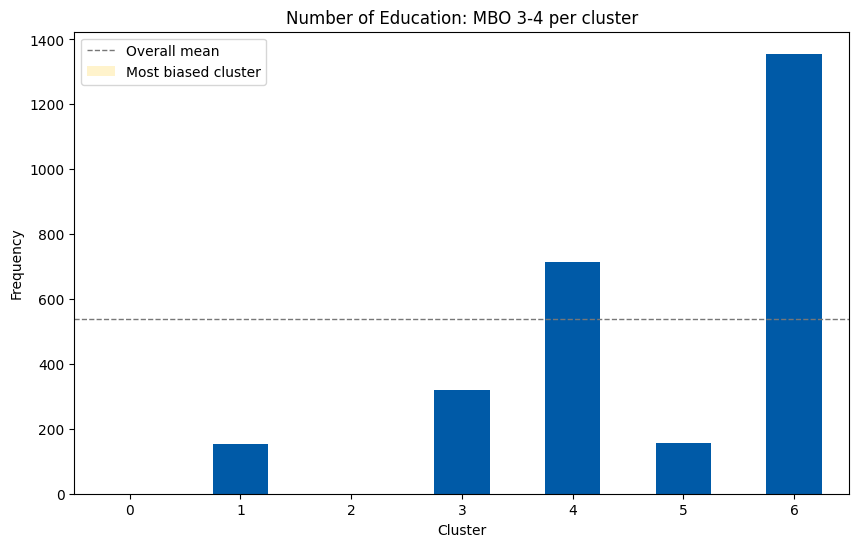

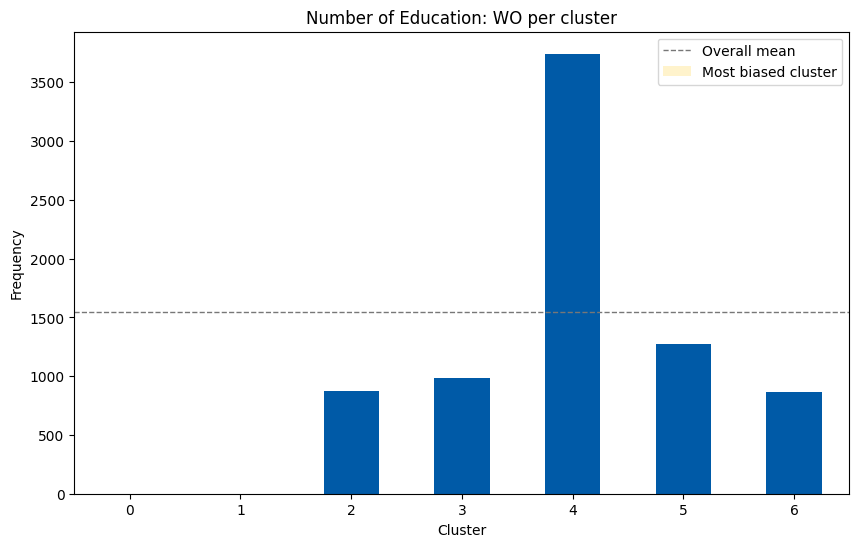

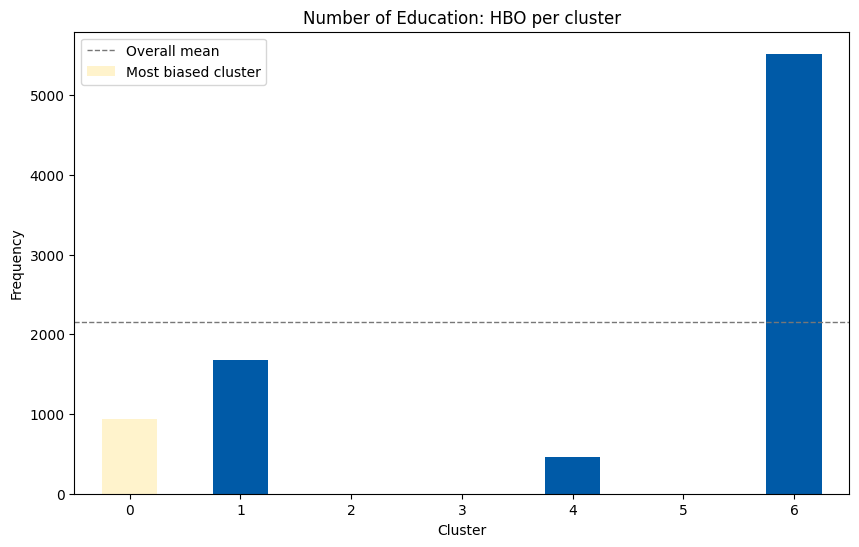

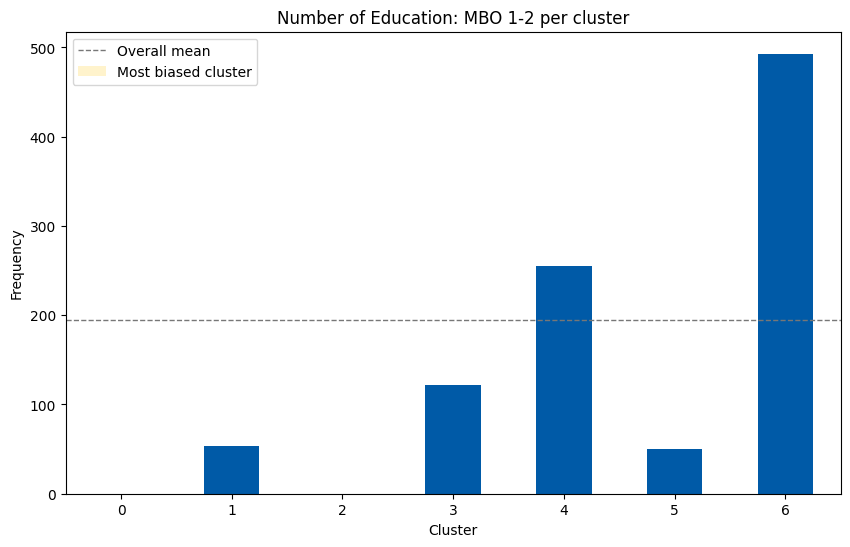

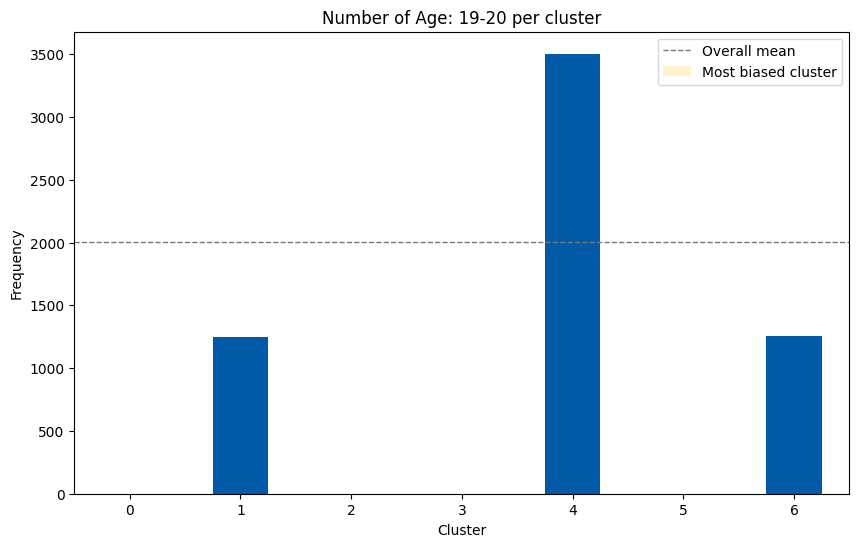

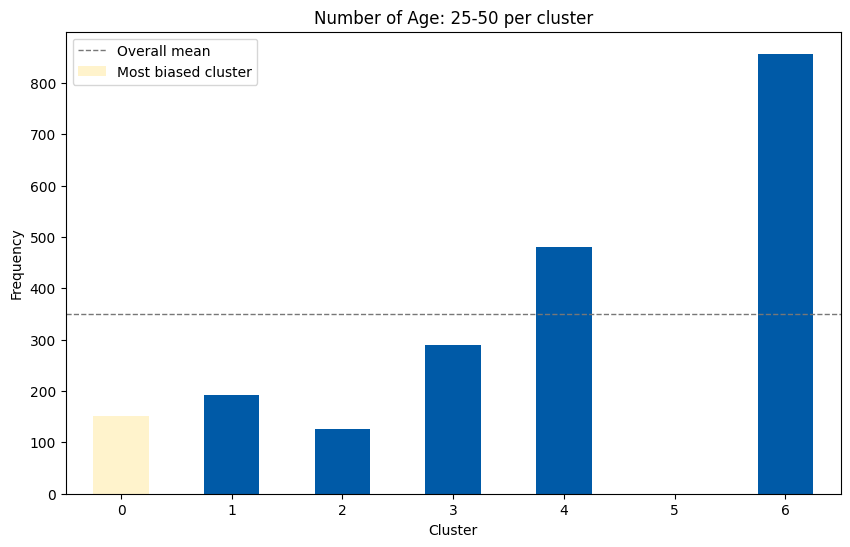

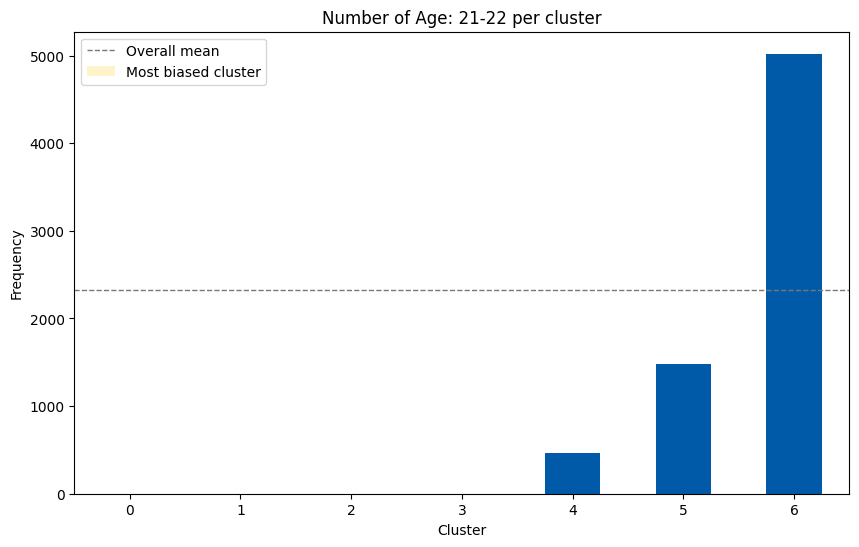

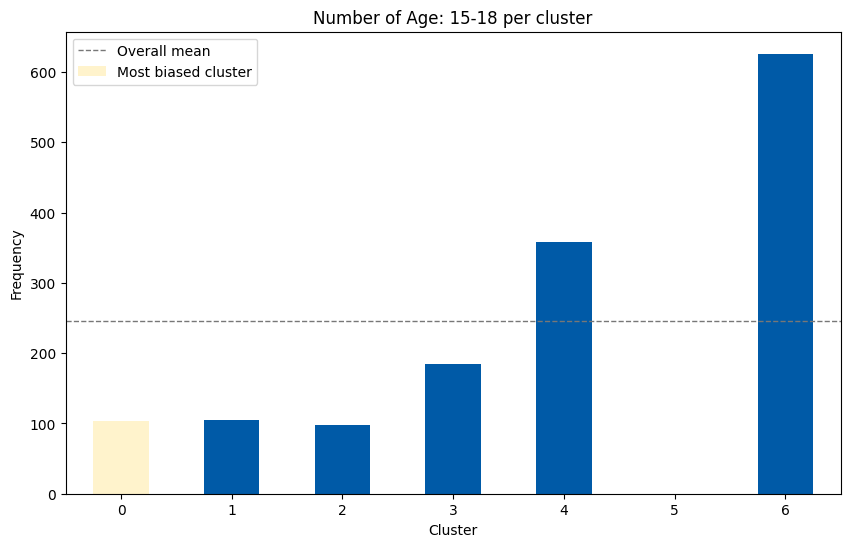

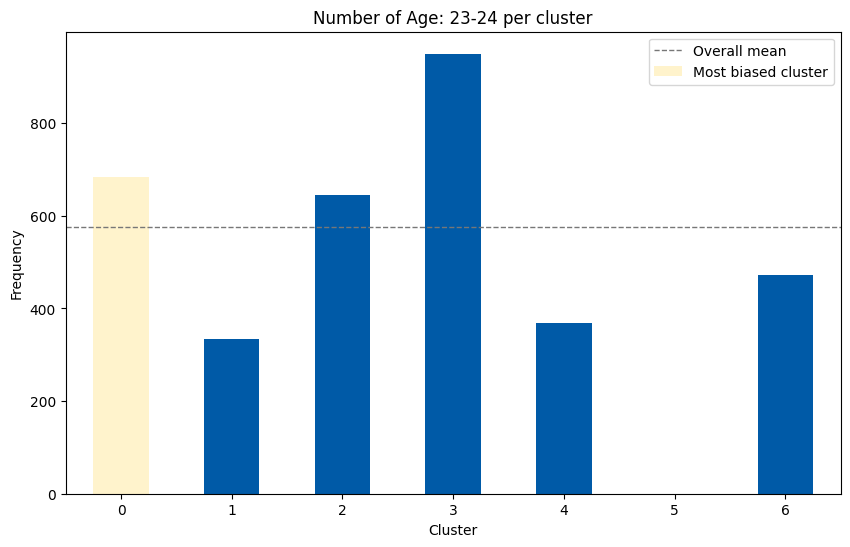

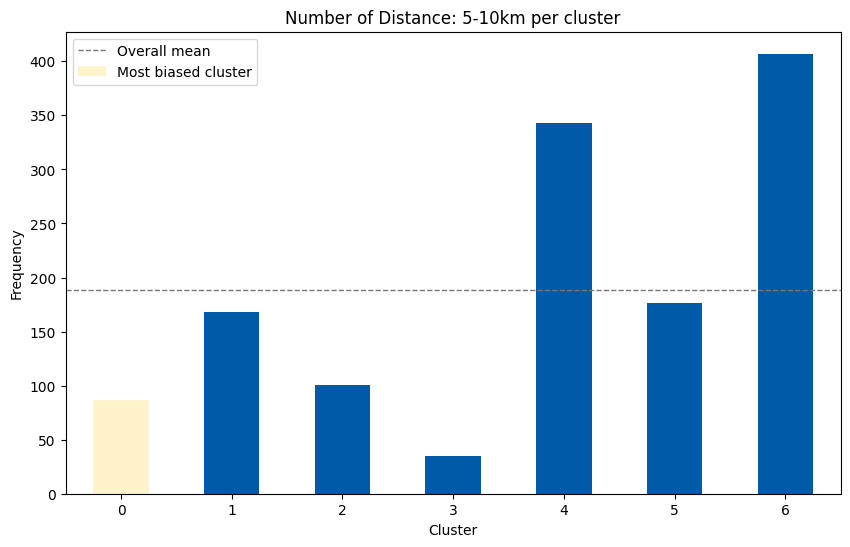

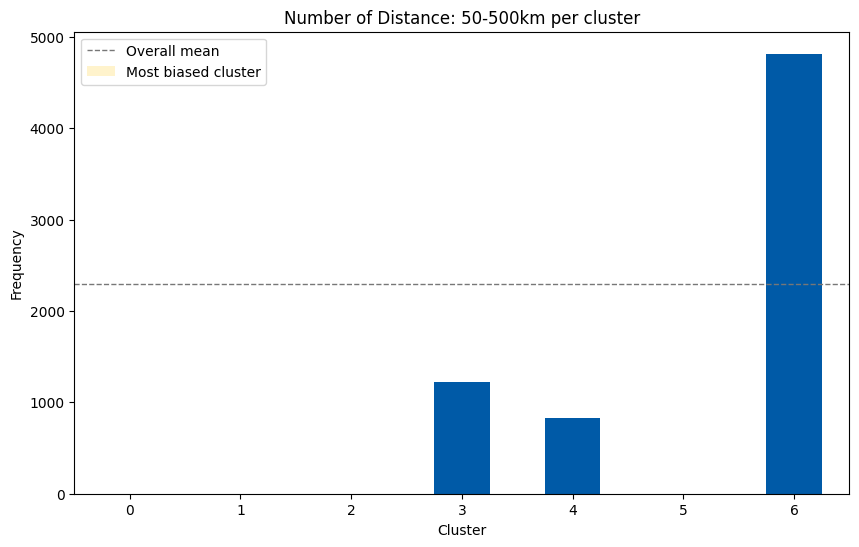

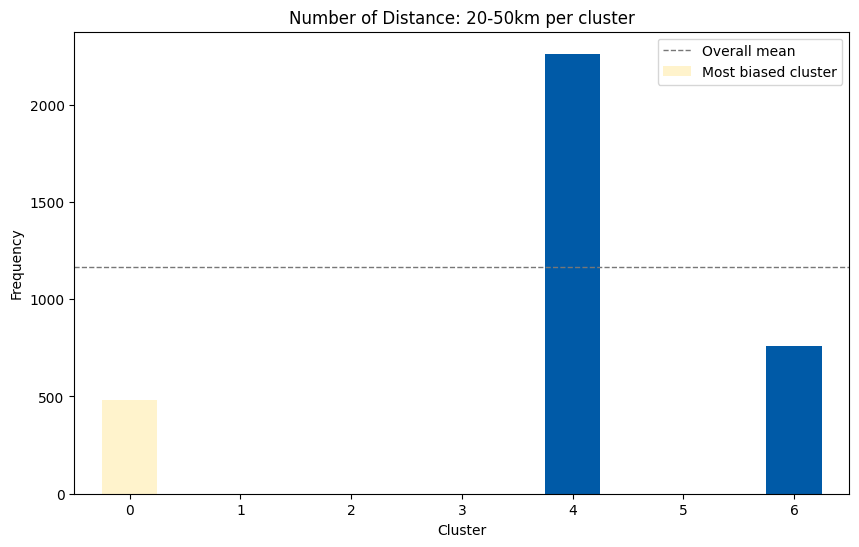

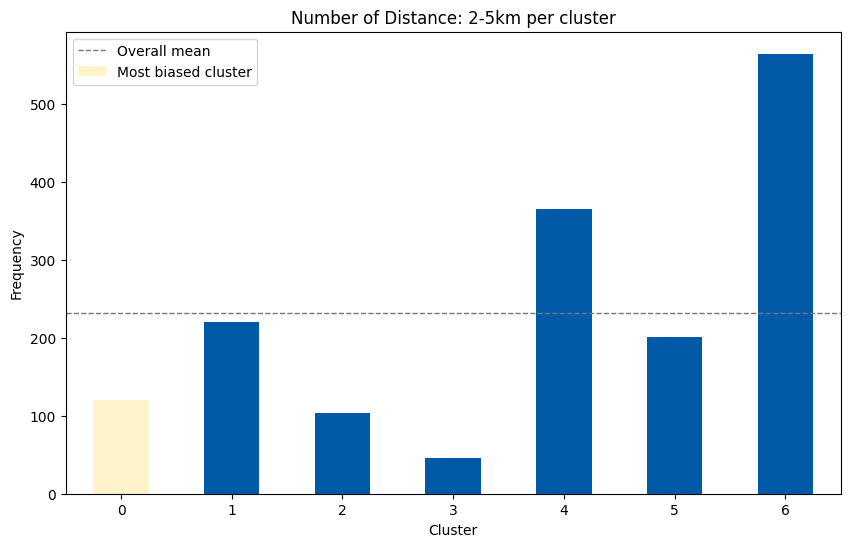

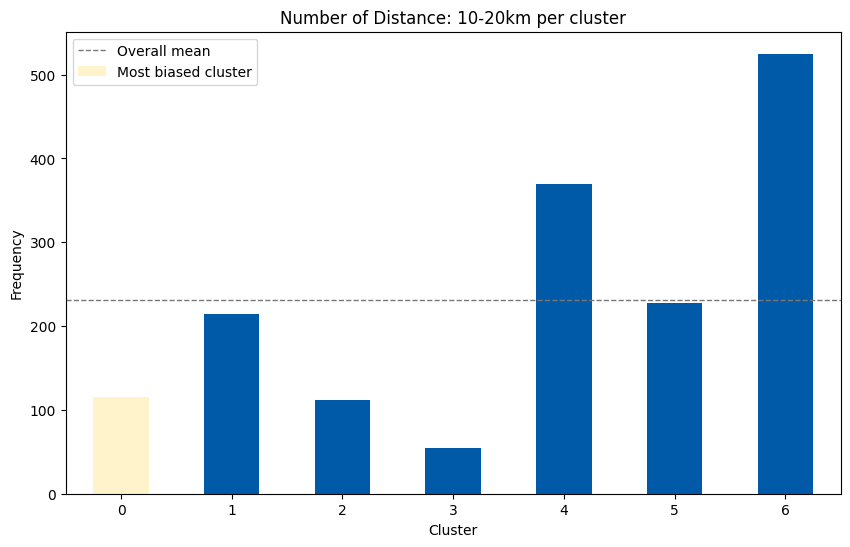

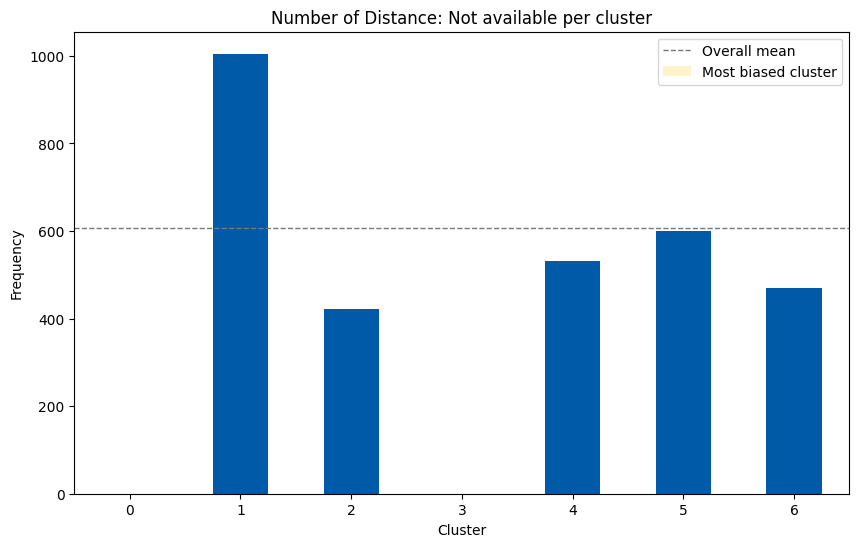

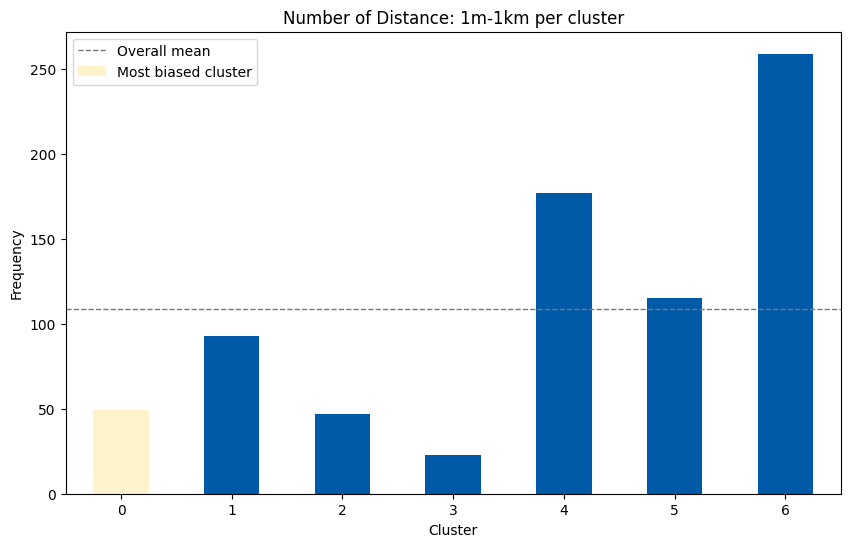

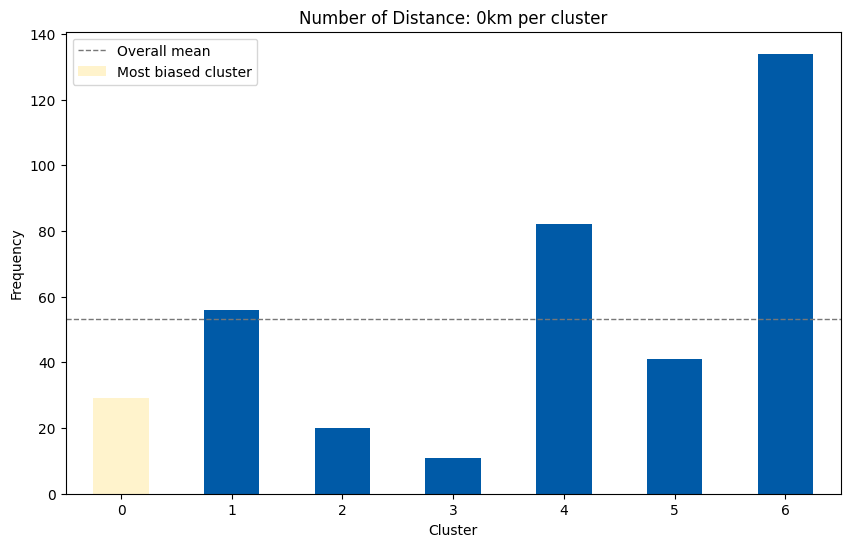

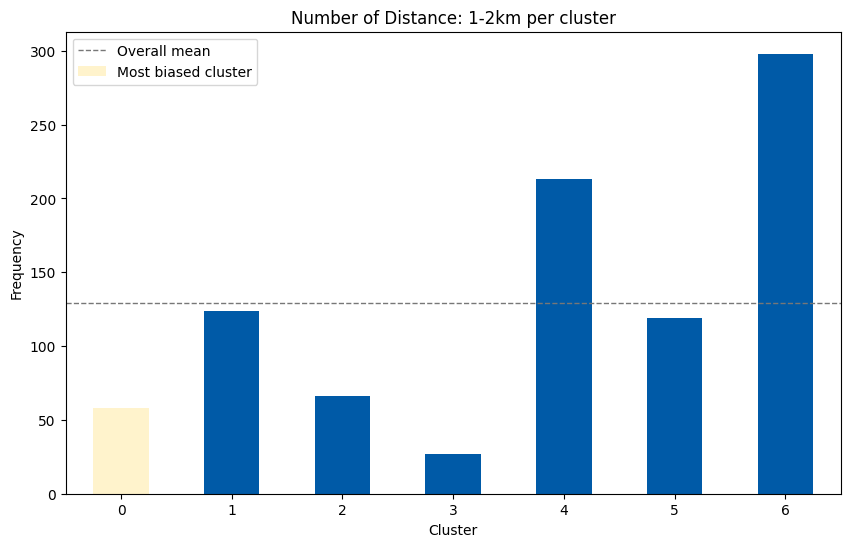

In [12]:
# Plot bar charts of features in df per cluster in separate plots
for feat in features:
    # all values per feature
    values = df[feat].unique().tolist()

    # range through all values
    for value in values:
        # Plot the number of values per cluster as a bar chart
        counts = df[df[feat] == value].groupby('Cluster').size()

        # plotting
        plt.figure(figsize=(10, 6))
        counts.reindex(range(hbac.n_clusters_), fill_value=0).plot(kind='bar', color=['#fff3cc' if i == 0 else '#005AA7' for i in range(hbac.n_clusters_)])
        plt.axhline(y=counts.values.mean(), color='#777', linestyle='--', linewidth=1)
        plt.title(f'Number of {feat}: {value} per cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Frequency')
        plt.xticks(rotation=0)
        plt.legend(['Overall mean','Most biased cluster'])
        plt.show()